# Detekcija emocija

## Imports

In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import keras
import nltk
import string
import re
import io
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM ,Conv2D, Dense, GlobalMaxPooling1D, GlobalAveragePooling2D, Flatten, Dropout , GRU, TimeDistributed, Conv1D, MaxPool1D, MaxPool2D, TextVectorization, Bidirectional, Reshape
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping
import matplotlib as mpl
import seaborn as sn

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
porter = PorterStemmer()
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nevena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Model Builder

In [2]:
class Model:
  def __init__(self, model_name, embedding_type, batch_size, validation_split, optimizer, loss, epochs):
    self.model_name = model_name
    self.embedding_type = embedding_type
    self.batch_size = batch_size
    self.validation_split = validation_split
    self.optimizer = optimizer
    self.loss = loss
    self.epochs = epochs
    self.classes = ["joy", "anger", "love", "sadness", "fear", "surprise"]

  def load_dataset(self):
    train = pd.read_csv(os.path.join("emotions-dataset-for-nlp", "train.txt"), names=['Text', 'Emotion'], sep=';')
    test = pd.read_csv(os.path.join("emotions-dataset-for-nlp", "test.txt"), names=['Text', 'Emotion'], sep=';')
    val = pd.read_csv(os.path.join("emotions-dataset-for-nlp", "val.txt"), names=['Text', 'Emotion'], sep=';')
    list_dataset = [train, test, val]
    self.dataset = pd.concat(list_dataset)

  def extract_features_and_labels(self):
    self.features = self.dataset['Text']
    self.labels = self.dataset['Emotion'] 

  def split_dataset(self):
    self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.features,
                                                                            self.labels, 
                                                                            test_size = self.validation_split)
  def clean_features(self):
    self.features = self.features.apply(lambda sequence:
                                              [l.lower() for l in sequence if l not in string.punctuation])
    self.features = self.features.apply(lambda word: ''.join(word))
    return self

  def _text_clean_pattern(self, text, pattern):
    text = re.sub(pattern, '', text)
    return text
  
  def clean_links(self):
    pattern = re.compile(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    self.features = self.features.map(lambda text: self._text_clean_pattern(text, pattern))
    return self

  def clean_tags(self):
    pattern = re.compile('<.*?>')
    self.features = self.features.map(lambda text: self._text_clean_pattern(text, pattern))
    return self

  def clean_numbers(self):
     pattern = re.compile('\d+')
     self.features = self.features.map(lambda text: self._text_clean_pattern(text, pattern))
     return self

  def _text_clean_abbreviations(self, text):
    text = re.sub(r"i['\s]?m\s", "i am ", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"\su['\s]r\s", " you are ", text)
    text = re.sub(r"he['\s]?s\s", "he is ", text)
    text = re.sub(r"she['\s]?s", "she is", text)
    text = re.sub(r"that['\s]?s", "that is", text)
    text = re.sub(r"what['\s]?s", "what is", text)
    text = re.sub(r"where['\s]?s", "where is", text)
    text = re.sub(r"[\'\s]ll\s", " will ", text)
    text = re.sub(r"[\'\s]ll\s", " will ", text)
    text = re.sub(r"[\'\s]ve\s", " have ", text)
    text = re.sub(r"[\'\s]re\s", " are ", text)
    text = re.sub(r"[\'\s]d\s", " would ", text)
    text = re.sub(r"won['\s]?t", "will not", text)
    text = re.sub(r"don['\s]?t", "do not", text)
    text = re.sub(r"didn['\s]?t", "did not", text)
    text = re.sub(r"can['\s]?t", "can not", text)
    text = re.sub(r"couldn['\s]?t", "could not", text)
    text = re.sub(r"haven['\s]?t", "have not", text)
    text = re.sub(r"\sw(?:\s|$)", " with ", text)
    text = re.sub(r"\stbh\s", " to be honest ", text)
    return text
  
  def clean_abbreviations(self):
    self.features = self.features.map(lambda text: self._text_clean_abbreviations(text))
    return self
  
  def tokenize(self):
    self.tokenizer = Tokenizer(num_words=5000)
    self.tokenizer.fit_on_texts(self.features)
    features = self.tokenizer.texts_to_sequences(self.features)
    self.features = pad_sequences(features)
    # self.labels = self.labels.replace(
    # {'joy': 0, 'anger': 1, 'love': 2, 'sadness': 3, 'fear': 4, 'surprise': 5})
    self.vocabulary_size = len(self.tokenizer.word_index)

  def make_labels_categorical(self):
    self.labels = self.labels.replace(
    {'joy': 0, 'anger': 1, 'love': 2, 'sadness': 3, 'fear': 4, 'surprise': 5})
    self.labels = to_categorical(self.labels, 6)

  def glove_word_embedding(self, file_name):
    self.embeddings_index = {}
    file_ = open(file_name, encoding='utf-8')
    for line in file_:
        arr = line.split()
        single_word = arr[0]
        w = np.asarray(arr[1:],dtype='float32')
        self.embeddings_index[single_word] = w
    file_.close()
    max_words = self.vocabulary_size + 1
    word_index = self.tokenizer.word_index
    self.embedding_matrix = np.zeros((max_words,300)).astype(object)
    for word , i in word_index.items():
            embedding_vector = self.embeddings_index.get(word)
            if embedding_vector is not None:
                self.embedding_matrix[i] = embedding_vector

  def init_model(self):
    m = Sequential()
    if self.embedding_type == 'tf-idf':
        vectorize_layer = TextVectorization(
        output_mode ='tf-idf',
        )
        vectorize_layer.adapt(self.X_train)
        m.add(tf.keras.Input(shape=(1, ), dtype=tf.string))
        m.add(vectorize_layer)
        m.add(Reshape((1, vectorize_layer.output_shape[1])))
        #m.add(tf.keras.layers.Reshape((1, 13536)))
    elif self.embedding_type == 'bow':
        m.add(
          Embedding(input_dim = self.vocabulary_size + 1, output_dim=64))
    else:
        m.add(Input(shape=(self.features.shape[1], )))
        m.add(Embedding(self.vocabulary_size + 1,300))
        m.layers[0].set_weights([self.embedding_matrix])
        m.layers[0].trainable = False
    
    self.model = m
    return self
  
  def add_layer(self, layer):
     self.model.add(layer)
     return self

  def compile_model(self, metrics):
    self.model.add(Dense(6, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))
    self.model.summary()
    self.model.compile(loss = self.loss, optimizer = self.optimizer, metrics = metrics)

  def fit(self, callbacks = None):
    if callbacks is None:
       self.history_training = self.model.fit(self.X_train, self.Y_train, epochs= self.epochs, batch_size = self.batch_size)
    else:
       self.history_training = self.model.fit(self.X_train, self.Y_train, epochs= self.epochs,batch_size = self.batch_size,
                                       callbacks = callbacks)
    plot_model(model=self.model, to_file=f'model\{self.model_name}.png', show_layer_names=False, show_shapes=True, show_layer_activations=True)
    

  def plot_train_history(self):
    plt.figure(figsize=(15, 10))
    plt.plot(self.history_training.history['accuracy'], c='b', label='train')
    # plt.plot(self.history_training.history['val_accuracy'], c='r', label='validation')
    plt.title("Model Accuracy vs Epochs")
    plt.xlabel("EPOCHS")
    plt.ylabel("ACCURACY")
    plt.legend(loc='lower right')
    plt.savefig(f'evaluation/{self.model_name}-accuracy.jpg')

    plt.figure(figsize=(15, 10))
    plt.plot(self.history_training.history['loss'], c='orange', label='train')
    # plt.plot(self.history_training.history['val_loss'], c='g', label='validation')
    plt.title("Model Loss vs Epochs")
    plt.xlabel("EPOCHS")
    plt.ylabel("LOSS")
    plt.legend(loc='upper right')
    plt.savefig(f'evaluation\{self.model_name}-loss.jpg')

  def test_model(self):
    self.model.evaluate(self.X_test, self.Y_test)
    Y_pred = self.model.predict(self.X_test)
    Y_pred = np.argmax(Y_pred, axis = 1)
    Y_test = np.argmax(self.Y_test, axis = 1)
    cm = confusion_matrix(Y_pred, Y_test, normalize='pred')
    cfm = pd.DataFrame(cm,
                     index = self.classes, 
                     columns = self.classes)
    plt.figure(figsize = (10, 7))
    cfm_plot = sn.heatmap(cfm, annot=True)
    cfm_plot.figure.savefig(f'evaluation\{self.model_name}-cfm.png')

    report = classification_report(Y_test, Y_pred)
    print(report)
    with io.open(f'evaluation/{self.model_name}-classificationreport.txt', 'w', encoding='utf-8') as f:
        f.write(report)



## RNN 

### Bi-LSTM Model

#### BOW, Bi-LSTM

In [3]:
model = Model('BOW_Bi-LSTM', 'bow', None, 0.1, 'adam', 'categorical_crossentropy', 15)
model.load_dataset()
model.extract_features_and_labels()

model.clean_features()
model.clean_links()
model.clean_tags()
model.clean_numbers()
model.clean_abbreviations()

model.tokenize()
model.make_labels_categorical()
model.split_dataset()
model.init_model()
model.add_layer(Dropout(0.5))
model.add_layer(Bidirectional(LSTM(64, return_sequences=True)))
model.add_layer(Bidirectional(LSTM(128)))
model.add_layer(Dropout(0.3))
model.add_layer(Dense(128, activation="relu"))

model.compile_model(metrics = ['accuracy'])
model.fit()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1102912   
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               3

63/63 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       659
           1       0.96      0.88      0.92       258
           2       0.90      0.85      0.87       174
           3       0.97      0.98      0.97       597
           4       0.90      0.87      0.88       242
           5       0.73      0.90      0.81        70

    accuracy                           0.93      2000
   macro avg       0.90      0.91      0.90      2000
weighted avg       0.94      0.93      0.93      2000



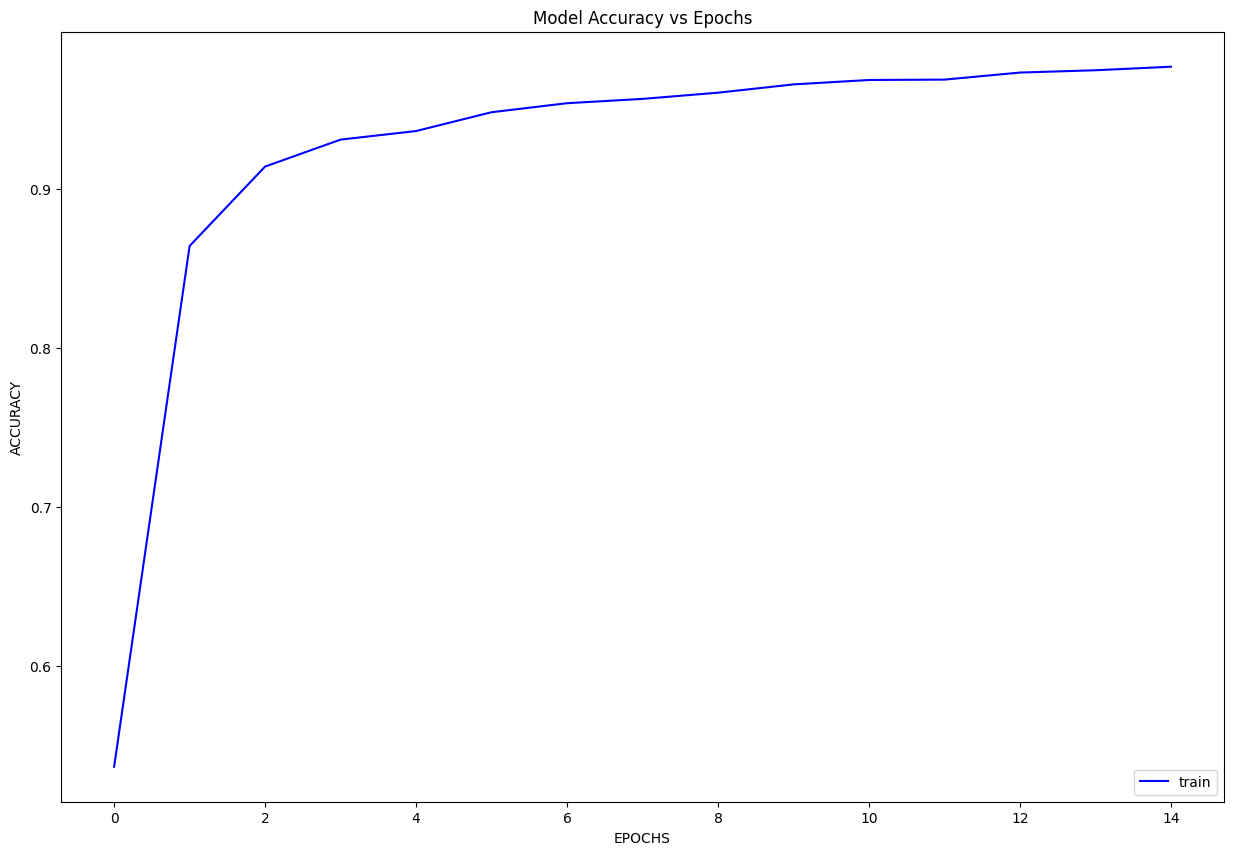

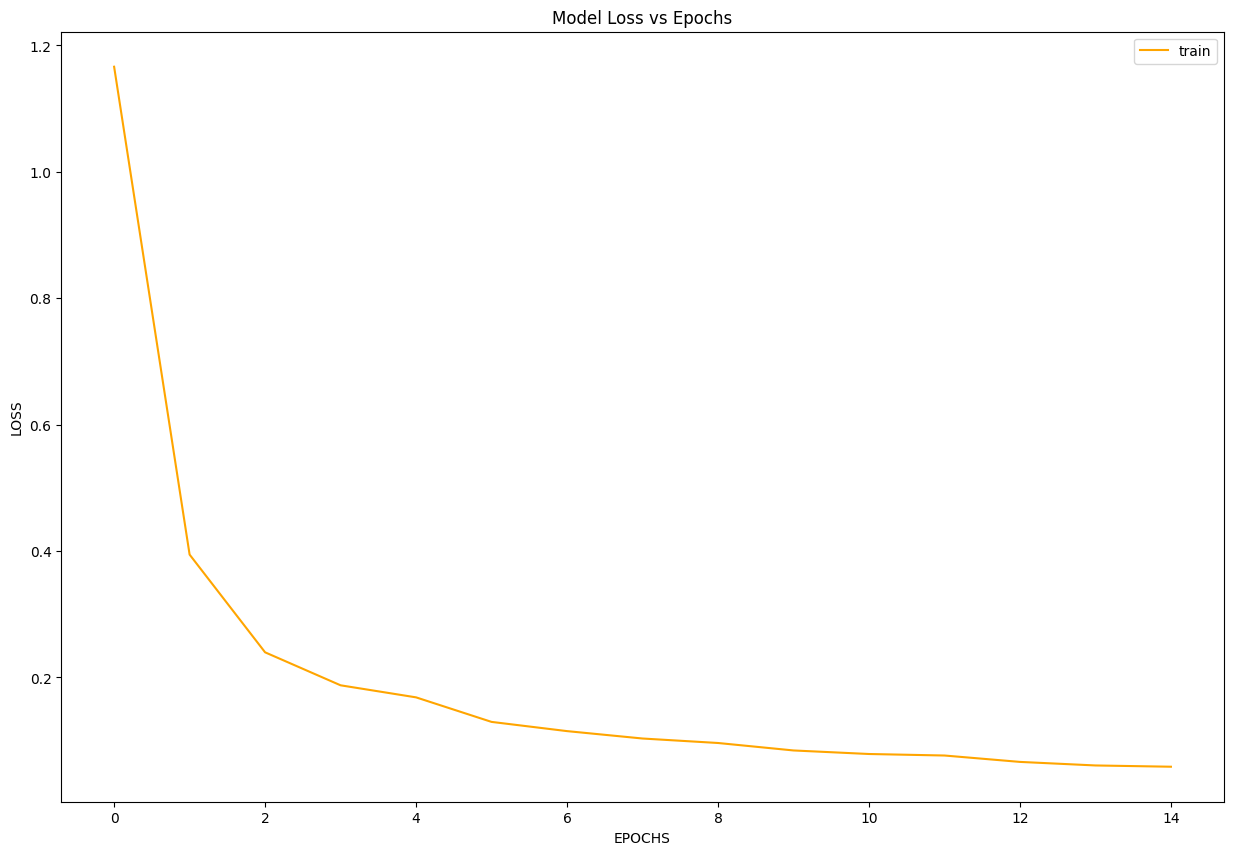

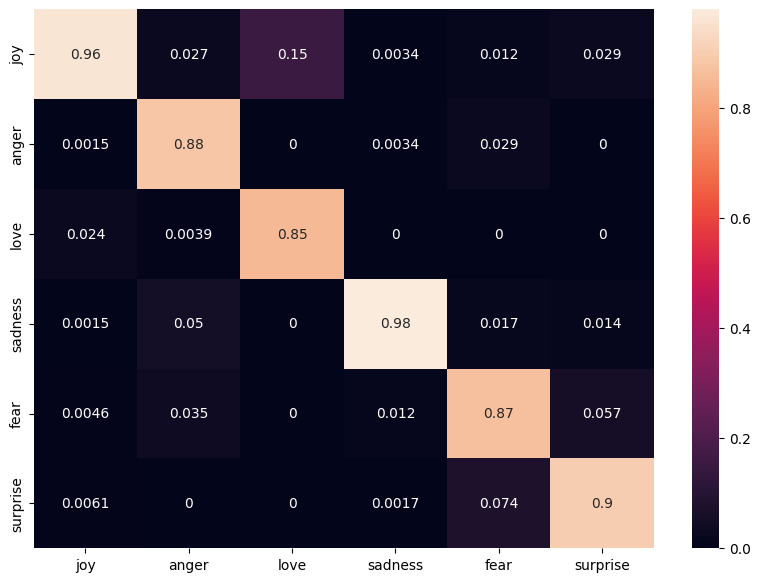

In [4]:
model.plot_train_history()
model.test_model()

#### TF-IDF, Bi-LSTM

In [5]:
model = Model('TF-IDF_Bi-LSTM', 'tf-idf', None, 0.1, 'adam', 'categorical_crossentropy', 15)
model.load_dataset()
model.extract_features_and_labels()

model.clean_features()
model.clean_links()
model.clean_tags()
model.clean_numbers()
model.clean_abbreviations()

#model.tokenize()
model.make_labels_categorical()
model.split_dataset()

print(model.X_train.shape)

model.init_model()
model.add_layer(Dense(128, activation="relu"))
model.add_layer(Dropout(0.5))  
model.add_layer(Bidirectional(LSTM(32, return_sequences=True)))
model.add_layer(Bidirectional(LSTM(64)))
model.add_layer(Dense(64, activation="relu"))
model.add_layer(Dropout(0.3))
model.add_layer(Dense(64, activation="relu"))

model.compile_model(metrics = ['accuracy'])
model.fit()

(18000,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 16284)            1         
 torization)                                                     
                                                                 
 reshape (Reshape)           (None, 1, 16284)          0         
                                                                 
 dense_2 (Dense)             (None, 1, 128)            2084480   
                                                                 
 dropout_2 (Dropout)         (None, 1, 128)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 64)            41216     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)    

63/63 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       671
           1       0.86      0.83      0.84       263
           2       0.82      0.58      0.68       169
           3       0.89      0.87      0.88       583
           4       0.91      0.73      0.81       249
           5       0.70      0.66      0.68        65

    accuracy                           0.84      2000
   macro avg       0.83      0.77      0.80      2000
weighted avg       0.85      0.84      0.84      2000



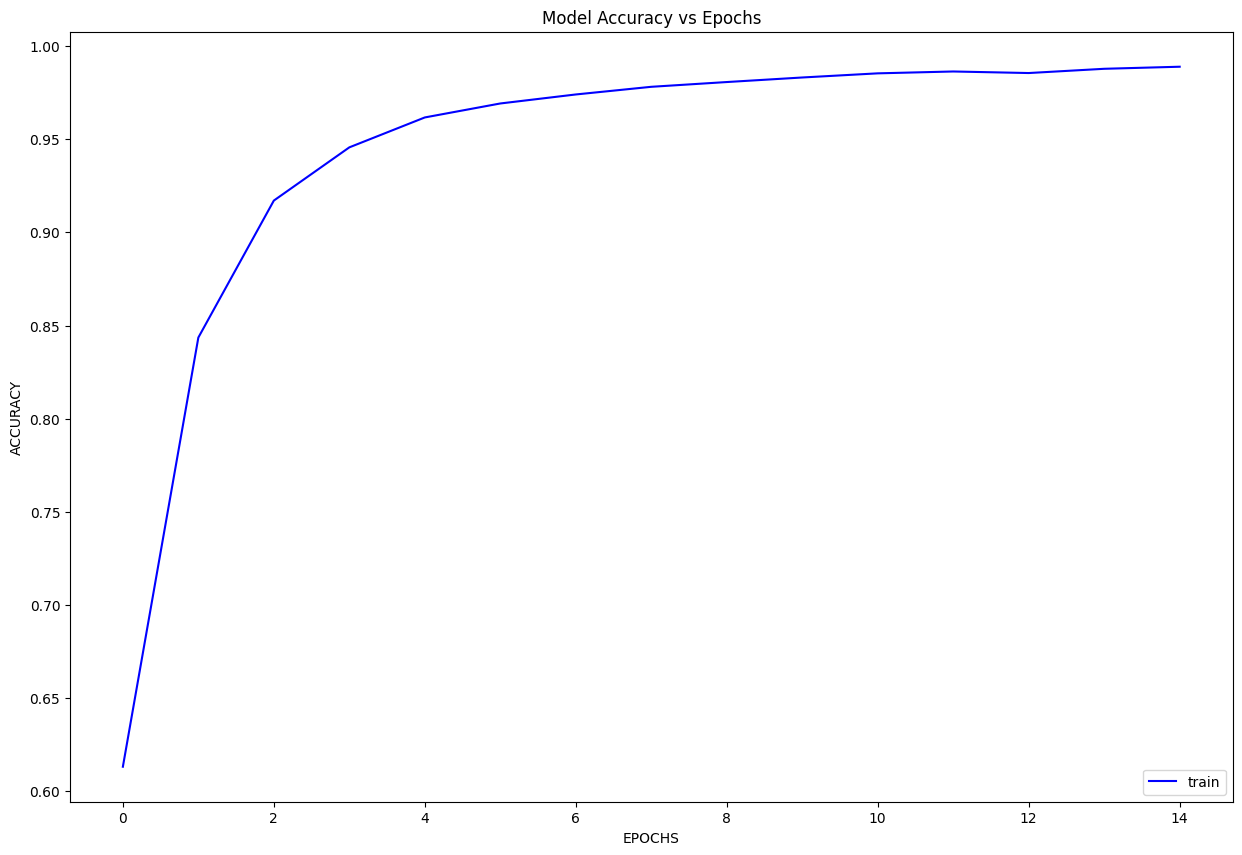

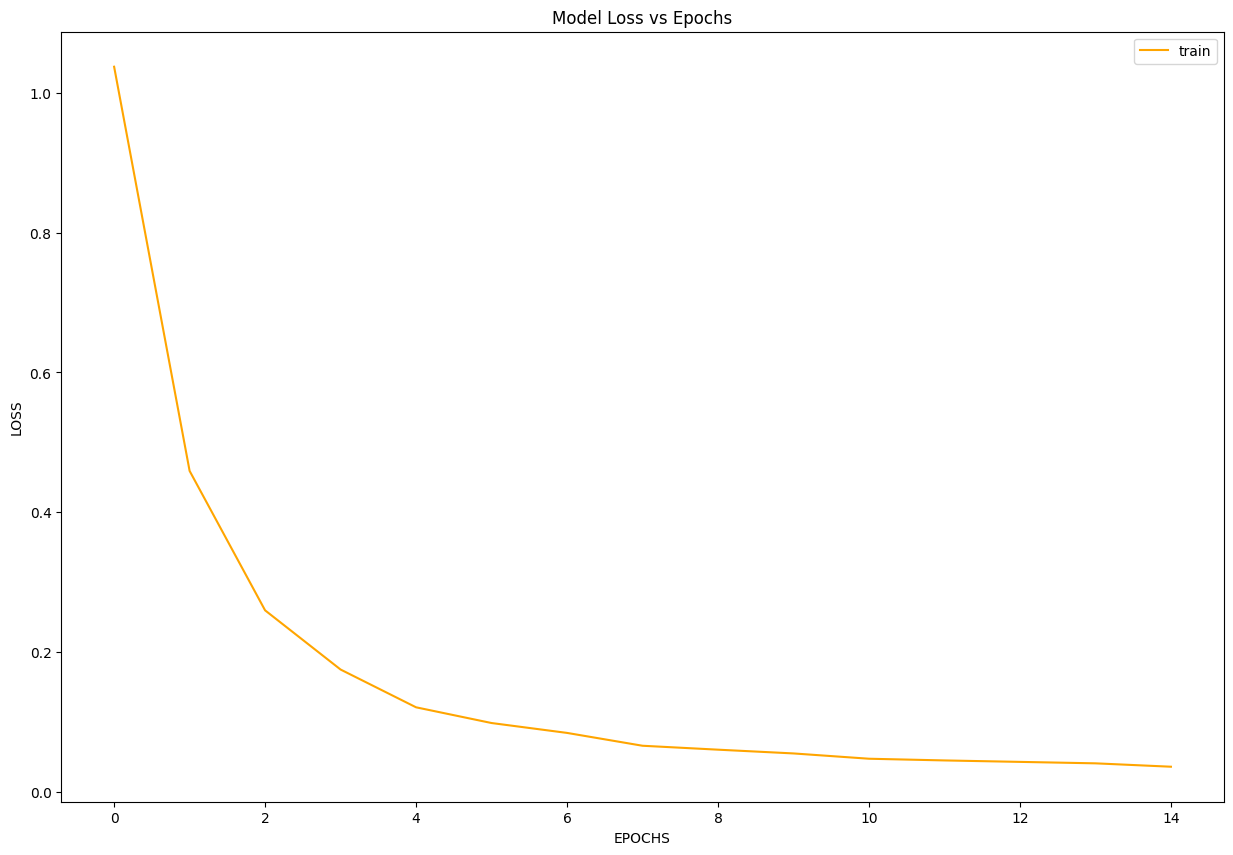

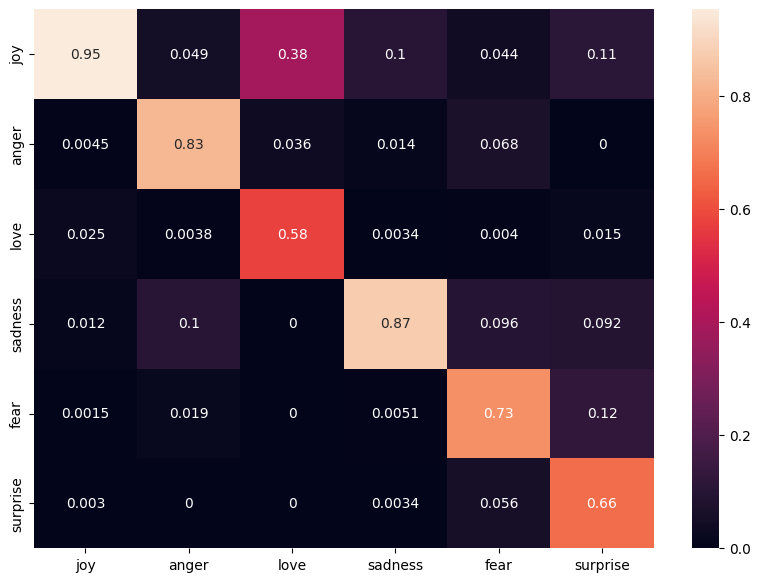

In [6]:
model.plot_train_history()
model.test_model()

#### GloVe, Bi-LSTM

(18000, 63)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 63, 300)           5129100   
                                                                 
 dense_6 (Dense)             (None, 63, 128)           38528     
                                                                 
 dropout_4 (Dropout)         (None, 63, 128)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 63, 64)           41216     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 64)   

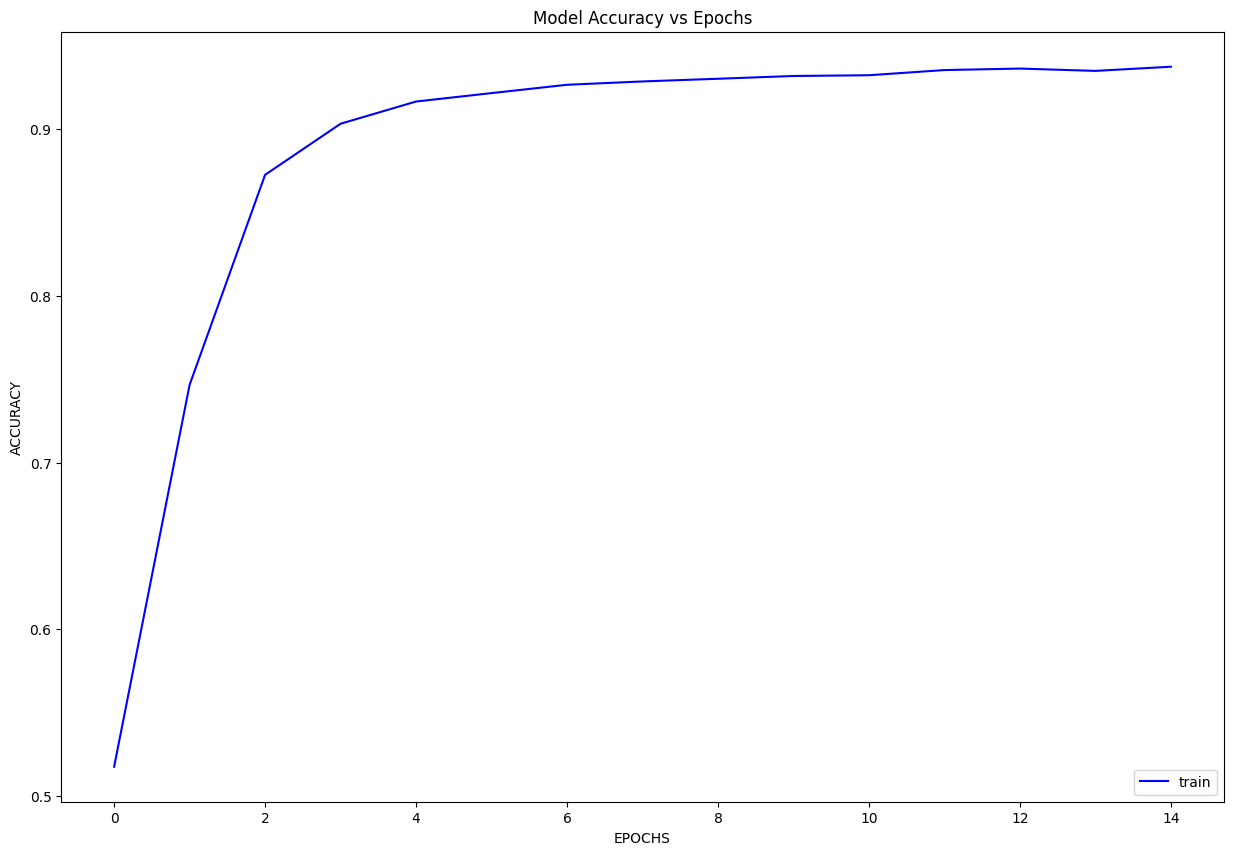

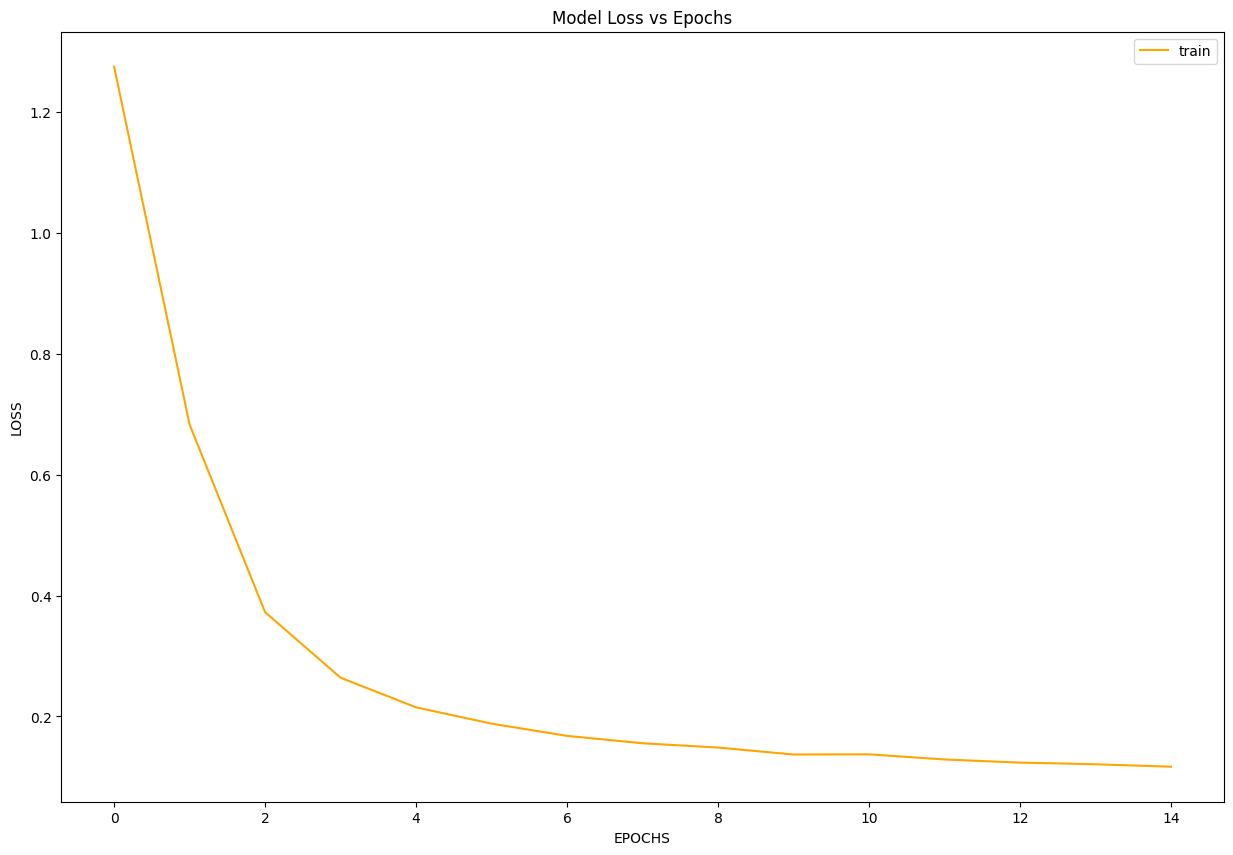

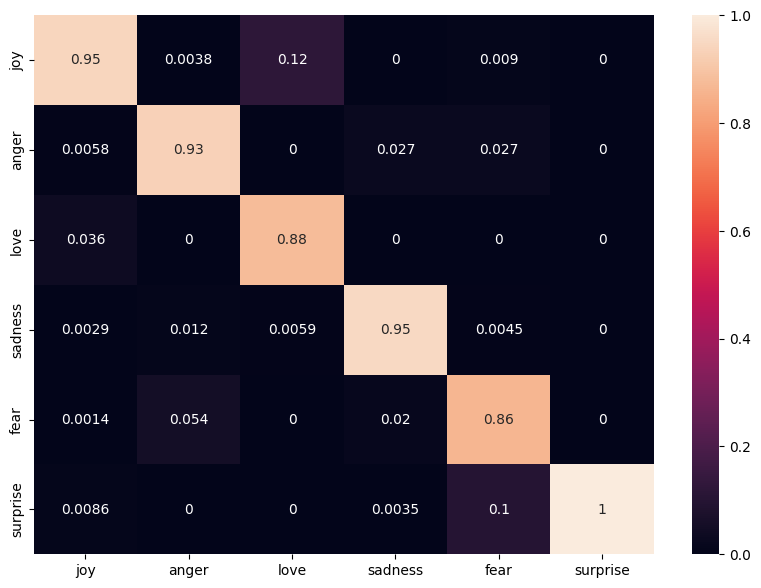

In [7]:
model = Model('GloVe_Bi-LSTM', '', None, 0.1, 'adam', 'categorical_crossentropy', 15)
model.load_dataset()
model.extract_features_and_labels()
model.clean_features()
model.tokenize()
model.make_labels_categorical()
model.split_dataset()
model.glove_word_embedding("glove.6B.300d.txt")

print(model.X_train.shape)

model.init_model()
model.add_layer(Dense(128, activation="relu"))
model.add_layer(Dropout(0.5))  
model.add_layer(Bidirectional(LSTM(32, return_sequences=True)))
model.add_layer(Bidirectional(LSTM(64)))
model.add_layer(Dense(64, activation="relu"))
model.add_layer(Dropout(0.3))
model.add_layer(Dense(64, activation="relu"))

model.compile_model(metrics = ['accuracy'])
model.fit()

model.plot_train_history()
model.test_model()

### GRU

#### BOW, GRU

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          1102912   
                                                                 
 gru (GRU)                   (None, 128)               74496     
                                                                 
 dense_10 (Dense)            (None, 6)                 774       
                                                                 
Total params: 1,178,182
Trainable params: 1,178,182
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
71/71 [==============================] - 11s 132ms/step - loss: 1.5721 - accuracy: 0.3593
Epoch 2/60
71/71 [==============================] - 10s 134ms/step - loss: 1.0776 - accuracy: 0.6157
Epoch 3/60
71/71 [==============================] - 9s 132ms/step - loss: 0.4852 - accuracy: 0.8571
Epoch 

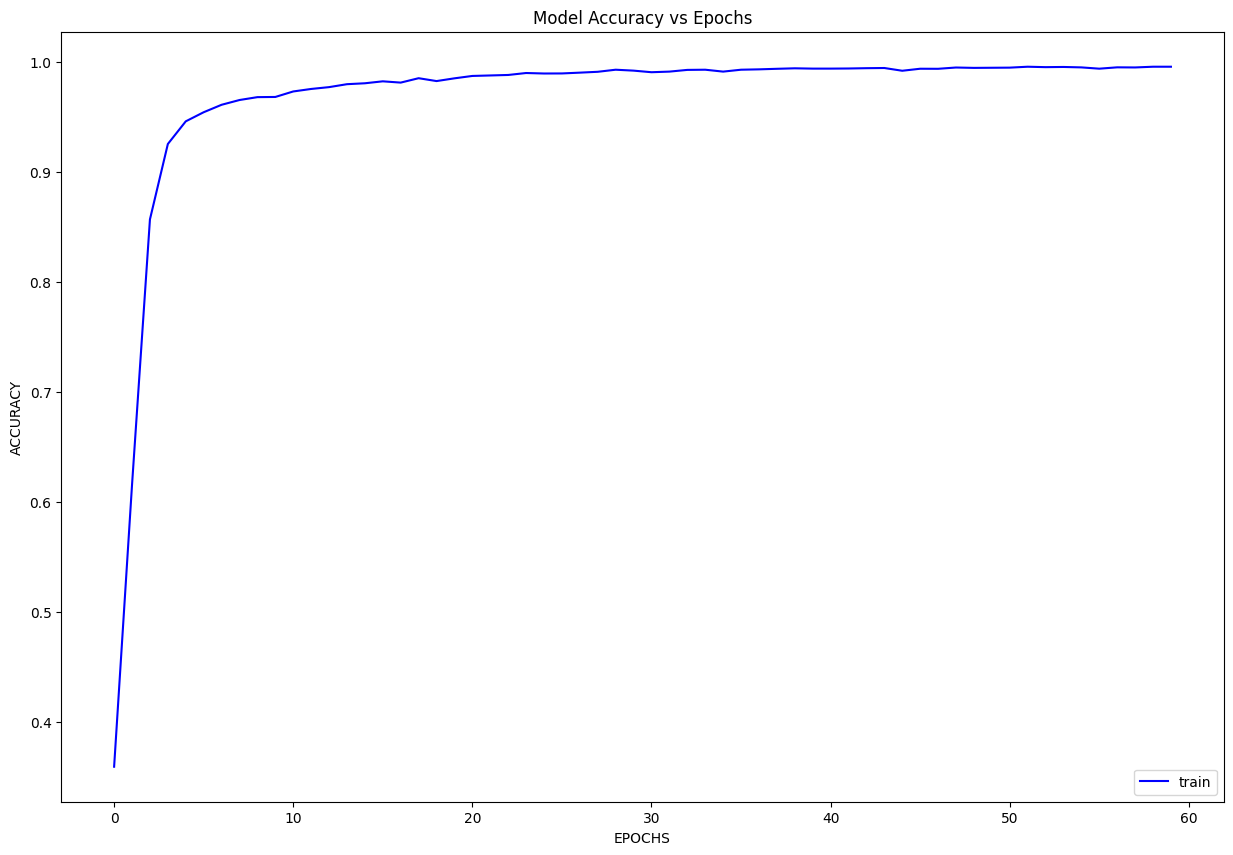

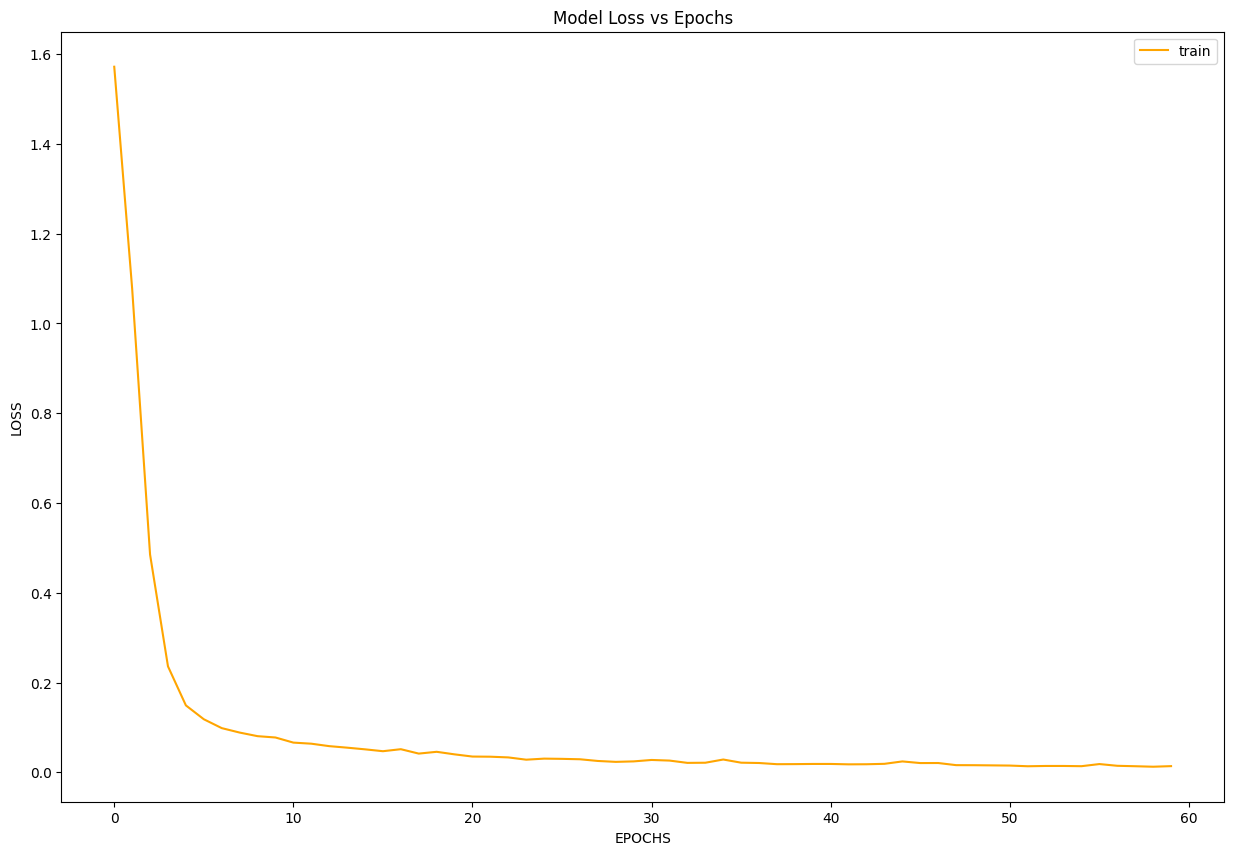

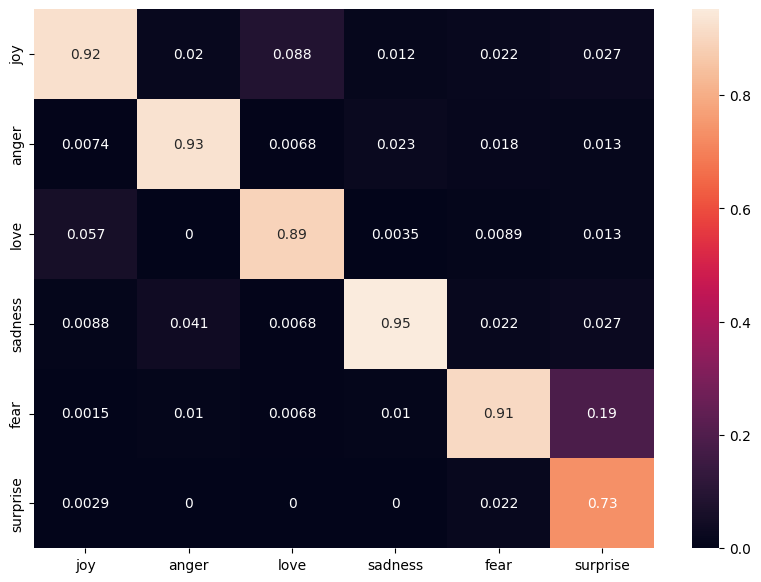

In [8]:
model = Model('BOW_GRU', 'bow', 256, 0.1, 'adam', 'categorical_crossentropy', 60)

model.load_dataset()
model.extract_features_and_labels()

model.clean_features()
model.clean_links()
model.clean_tags()
model.clean_numbers()
model.clean_abbreviations()

model.tokenize()
model.make_labels_categorical()
model.split_dataset()

model.init_model()
model.add_layer(GRU(128, recurrent_dropout=0.3, return_sequences=False, activity_regularizer = tf.keras.regularizers.L2(0.0001)))
model.compile_model(metrics = ['accuracy'])

earlyStopping = EarlyStopping(monitor = 'loss', patience = 20, mode = 'min', restore_best_weights = True)
model.fit([earlyStopping])

model.plot_train_history()
model.test_model()

#### TF-IDF, GRU

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 16245)            1         
 ectorization)                                                   
                                                                 
 reshape_1 (Reshape)         (None, 1, 16245)          0         
                                                                 
 gru_1 (GRU)                 (None, 128)               6288000   
                                                                 
 dense_11 (Dense)            (None, 6)                 774       
                                                                 
Total params: 6,288,775
Trainable params: 6,288,774
Non-trainable params: 1
_________________________________________________________________
Epoch 1/60
71/71 [==============================] - 2s 16ms/step - loss: 0.9959 - accuracy: 0.7042
Epoch 2/60


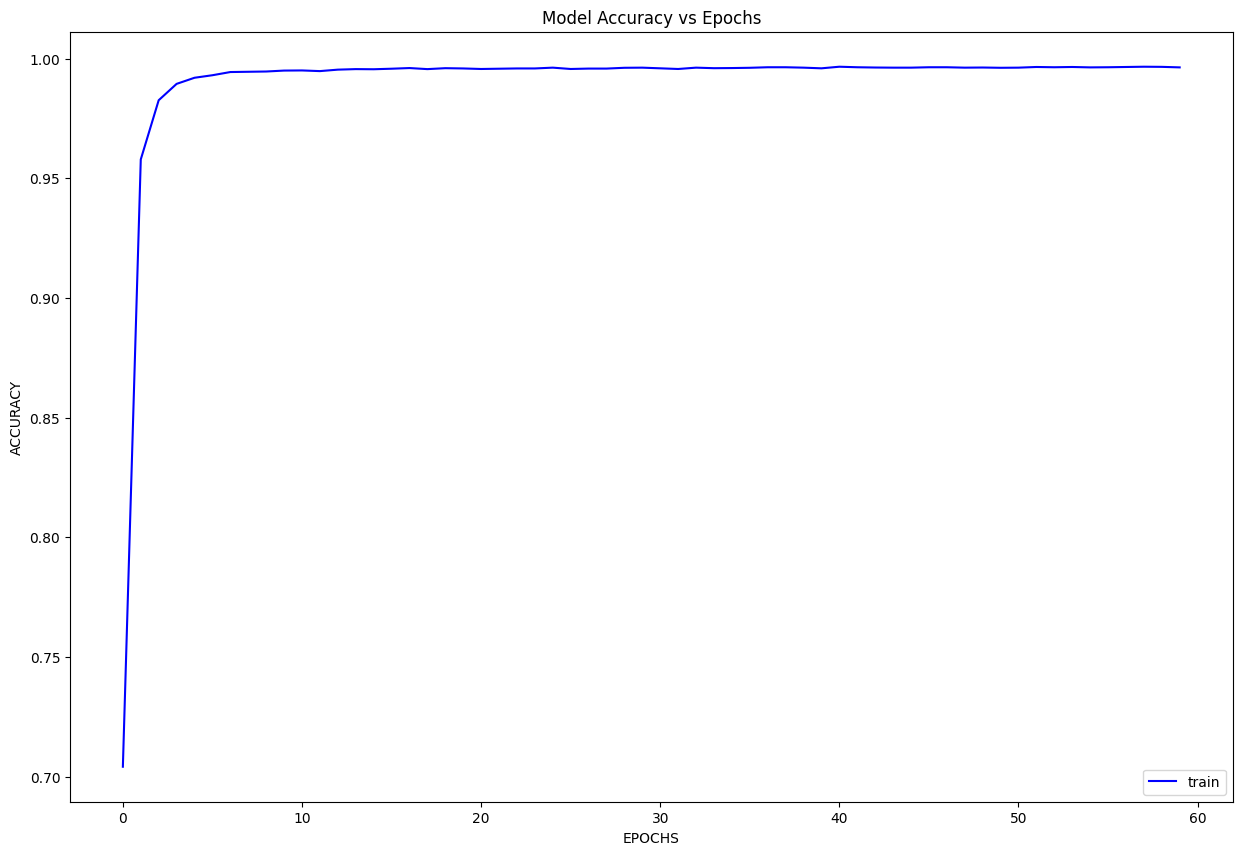

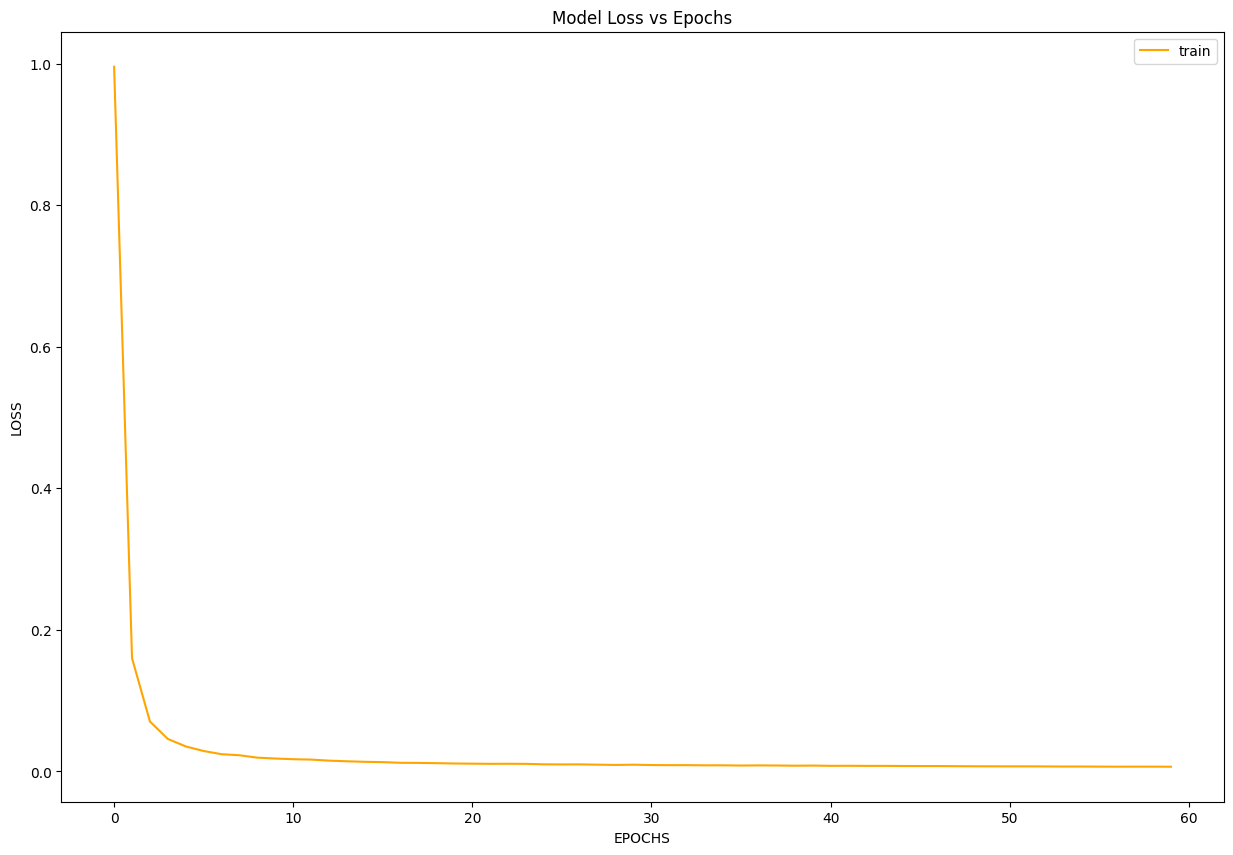

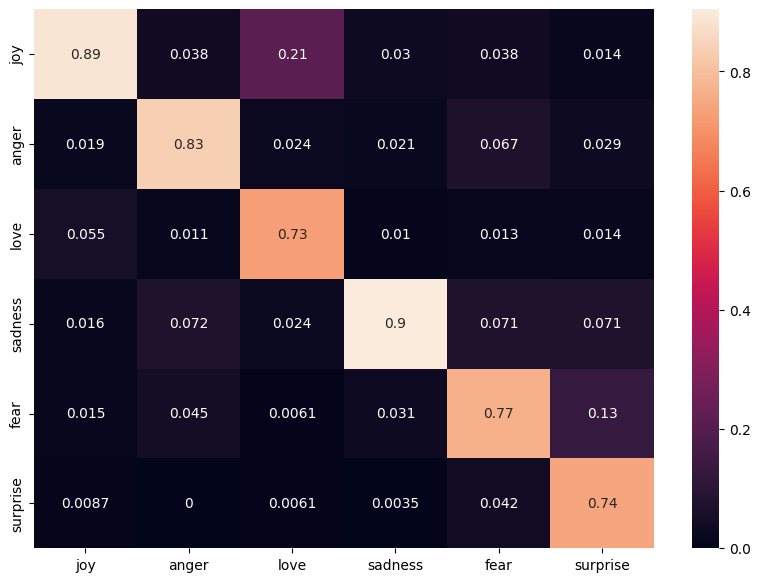

In [9]:
model = Model('TF-IDF_GRU', 'tf-idf', 256, 0.1, 'adam', 'categorical_crossentropy', 60)

model.load_dataset()
model.extract_features_and_labels()

model.clean_features()
model.clean_links()
model.clean_tags()
model.clean_numbers()
model.clean_abbreviations()

model.make_labels_categorical()
model.split_dataset()

model.init_model()
model.add_layer(GRU(128, recurrent_dropout=0.3, return_sequences=False, activity_regularizer = tf.keras.regularizers.L2(0.0001)))
model.compile_model(metrics = ['accuracy'])

earlyStopping = EarlyStopping(monitor = 'loss', patience = 20, mode = 'min', restore_best_weights = True)
model.fit([earlyStopping])

model.plot_train_history()
model.test_model()

#### GloVe, GRU

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 63, 300)           5129100   
                                                                 
 gru_2 (GRU)                 (None, 128)               165120    
                                                                 
 dense_12 (Dense)            (None, 6)                 774       
                                                                 
Total params: 5,294,994
Trainable params: 165,894
Non-trainable params: 5,129,100
_________________________________________________________________
Epoch 1/60
71/71 [==============================] - 10s 117ms/step - loss: 1.3758 - accuracy: 0.4891
Epoch 2/60
71/71 [==============================] - 8s 117ms/step - loss: 0.7728 - accuracy: 0.7317
Epoch 3/60
71/71 [==============================] - 8s 119ms/step - loss: 0.4189 - accuracy: 0.8578
E

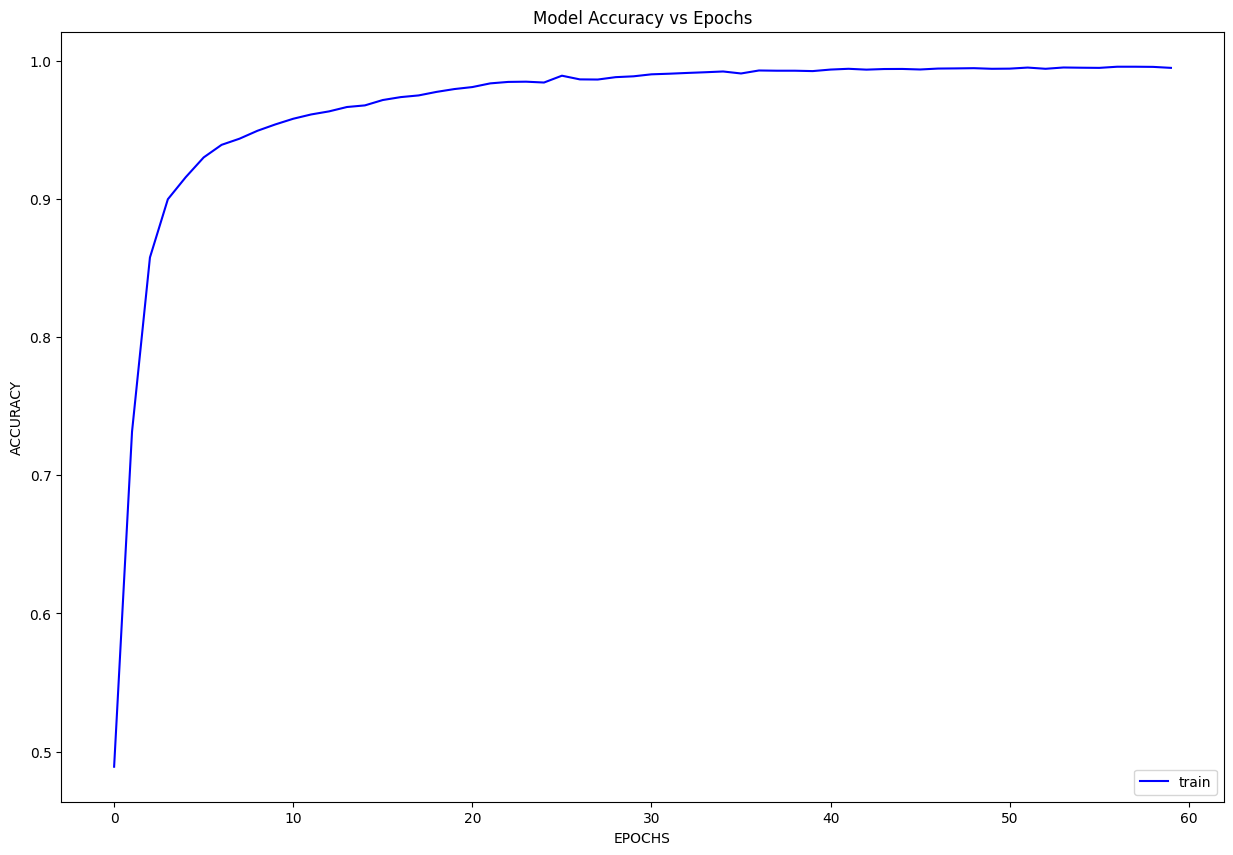

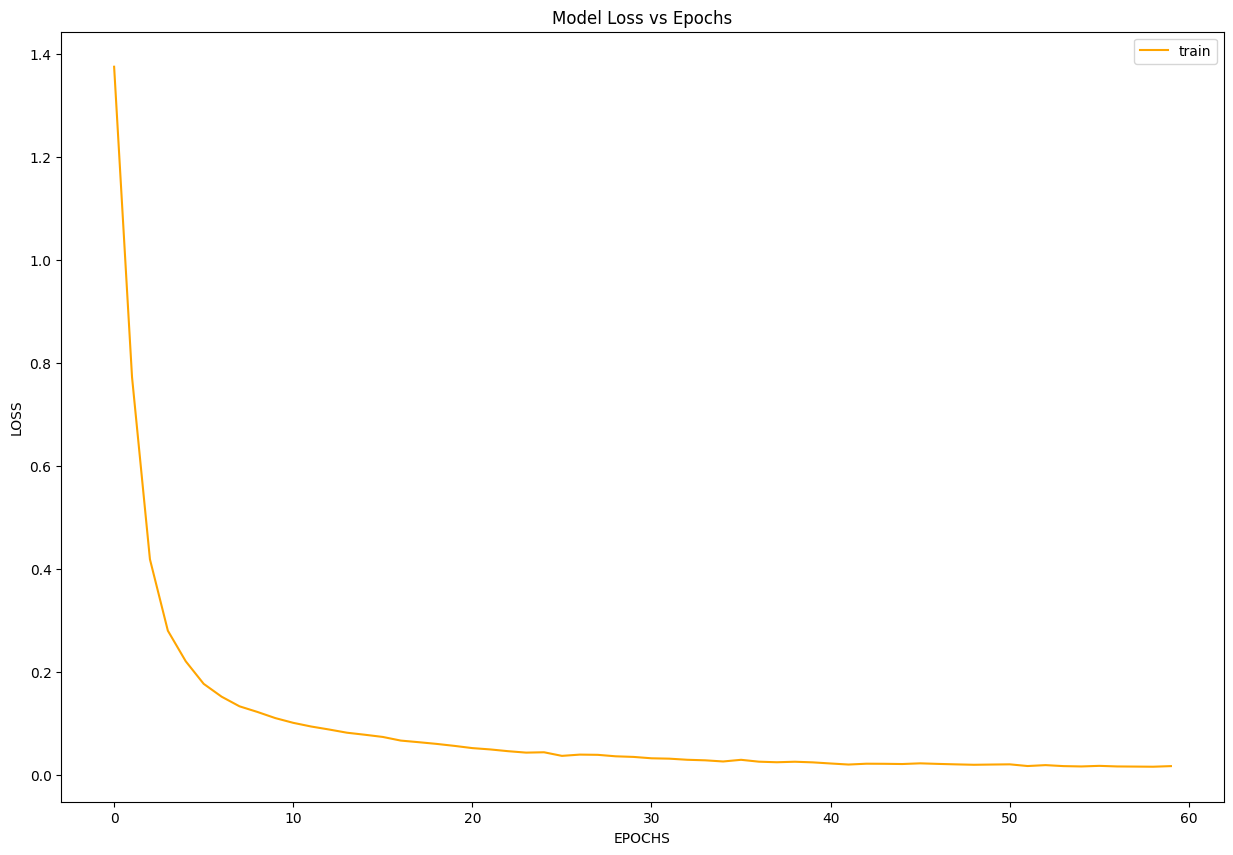

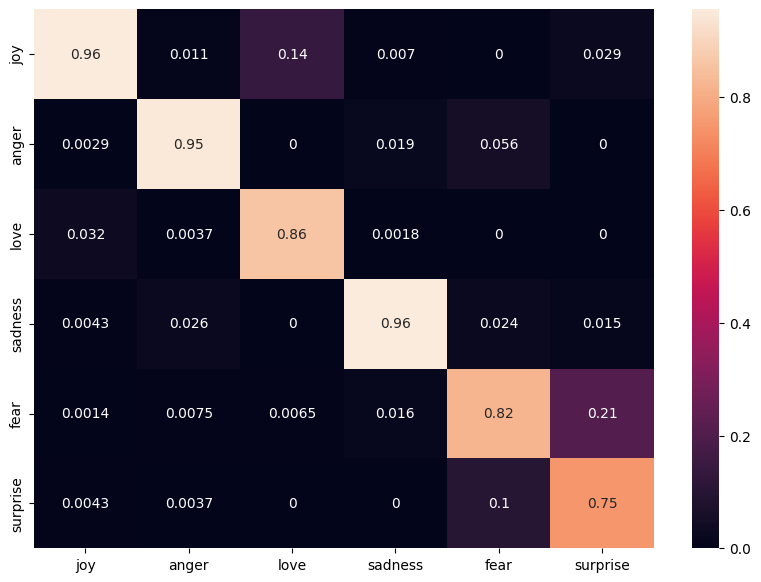

In [10]:
model = Model('GloVe_GRU', '', 256, 0.1, 'adam', 'categorical_crossentropy', 60)

model.load_dataset()
model.extract_features_and_labels()
model.clean_features()
model.tokenize()
model.make_labels_categorical()
model.split_dataset()
model.glove_word_embedding("glove.6B.300d.txt")

model.init_model()
model.add_layer(GRU(128, recurrent_dropout=0.3, return_sequences=False, activity_regularizer = tf.keras.regularizers.L2(0.0001)))
model.compile_model(metrics = ['accuracy'])

earlyStopping = EarlyStopping(monitor = 'loss', patience = 20, mode = 'min', restore_best_weights = True)
model.fit([earlyStopping])

model.plot_train_history()
model.test_model()

## CNN-1


In [11]:
model = Model('GloVe_CNN', '', 256, 0.1, 'adam', 'categorical_crossentropy', 30)

model.load_dataset()
model.extract_features_and_labels()
model.clean_features()
model.tokenize()
model.make_labels_categorical()
model.split_dataset()
model.glove_word_embedding("glove.6B.300d.txt")

model.init_model()

model.add_layer(Conv1D(32, 3, activation='relu'))
model.add_layer(MaxPool1D())
model.add_layer(Flatten())
model.add_layer(Dense(150, activation='relu'))
model.compile_model(metrics = ['accuracy'])

earlyStopping = EarlyStopping(monitor = 'loss', patience = 15, mode = 'min', restore_best_weights = True)
model.fit([earlyStopping])


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 63, 300)           5129100   
                                                                 
 conv1d (Conv1D)             (None, 61, 32)            28832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense_13 (Dense)            (None, 150)               144150    
                                                                 
 dense_14 (Dense)            (None, 6)                 906       
                                                      

63/63 [==============================] - 0s 950us/step
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       690
           1       0.75      0.66      0.70       299
           2       0.61      0.63      0.62       156
           3       0.74      0.77      0.75       549
           4       0.60      0.71      0.65       233
           5       0.55      0.42      0.48        73

    accuracy                           0.73      2000
   macro avg       0.68      0.66      0.67      2000
weighted avg       0.73      0.73      0.73      2000



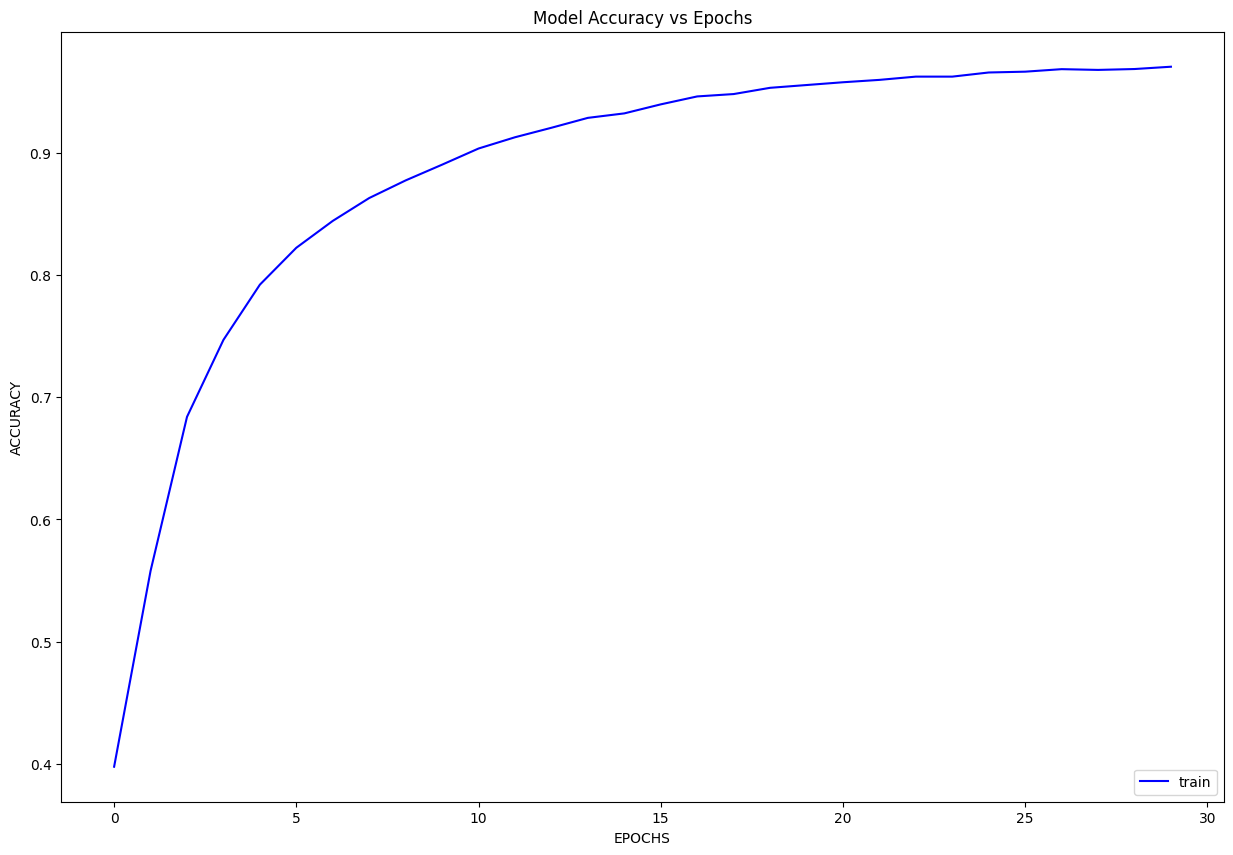

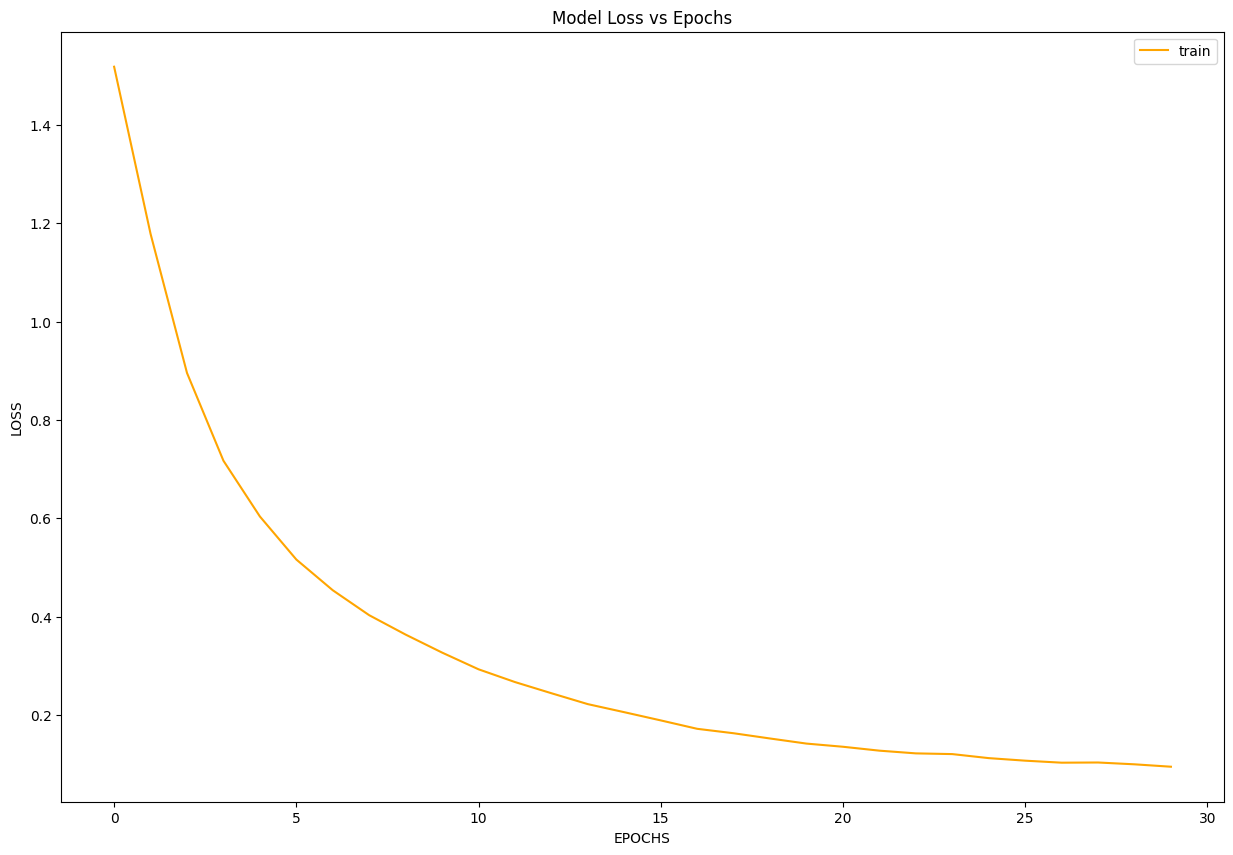

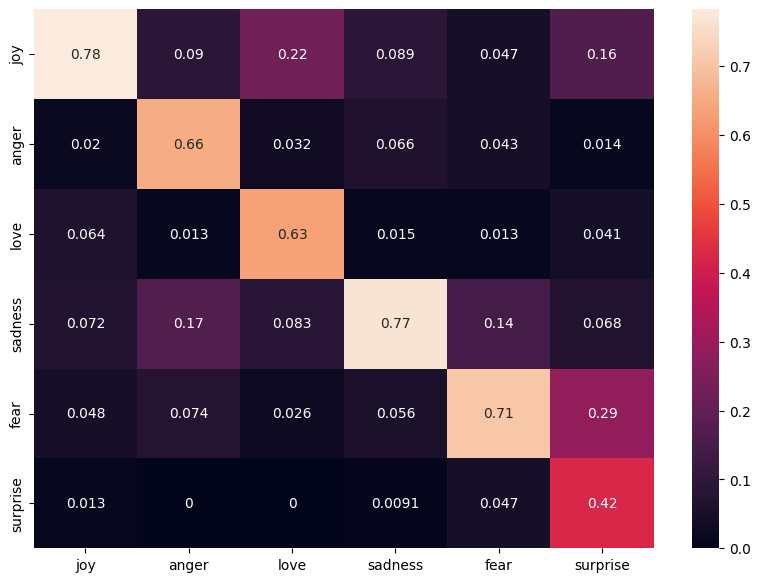

In [12]:
model.plot_train_history()
model.test_model()

## CNN-2

In [13]:
model = Model('GloVe_CNN2', '', 256, 0.1, 'adam', 'categorical_crossentropy', 60)

model.load_dataset()
model.extract_features_and_labels()
model.clean_features()
model.tokenize()
model.make_labels_categorical()
model.split_dataset()
model.glove_word_embedding("glove.6B.300d.txt")

model.init_model()

model.add_layer(Conv1D(64, 3, activation='relu'))
model.add_layer(MaxPool1D())
model.add_layer(Conv1D(32, 3, activation='relu'))
model.add_layer(MaxPool1D())
model.add_layer(Conv1D(32, 3, activation='relu'))
model.add_layer(MaxPool1D())
model.add_layer(Flatten())
model.add_layer(Dense(512, activation='relu'))
model.add_layer(Dropout(0.5))
model.compile_model(metrics = ['accuracy'])

earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
model.fit([earlyStopping])


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 63, 300)           5129100   
                                                                 
 conv1d_1 (Conv1D)           (None, 61, 64)            57664     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 30, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 28, 32)            6176      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 14, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 12, 32)           

63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       673
           1       0.69      0.76      0.72       260
           2       0.64      0.68      0.66       165
           3       0.80      0.80      0.80       581
           4       0.70      0.72      0.71       247
           5       0.61      0.47      0.53        74

    accuracy                           0.76      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.76      0.76      0.76      2000



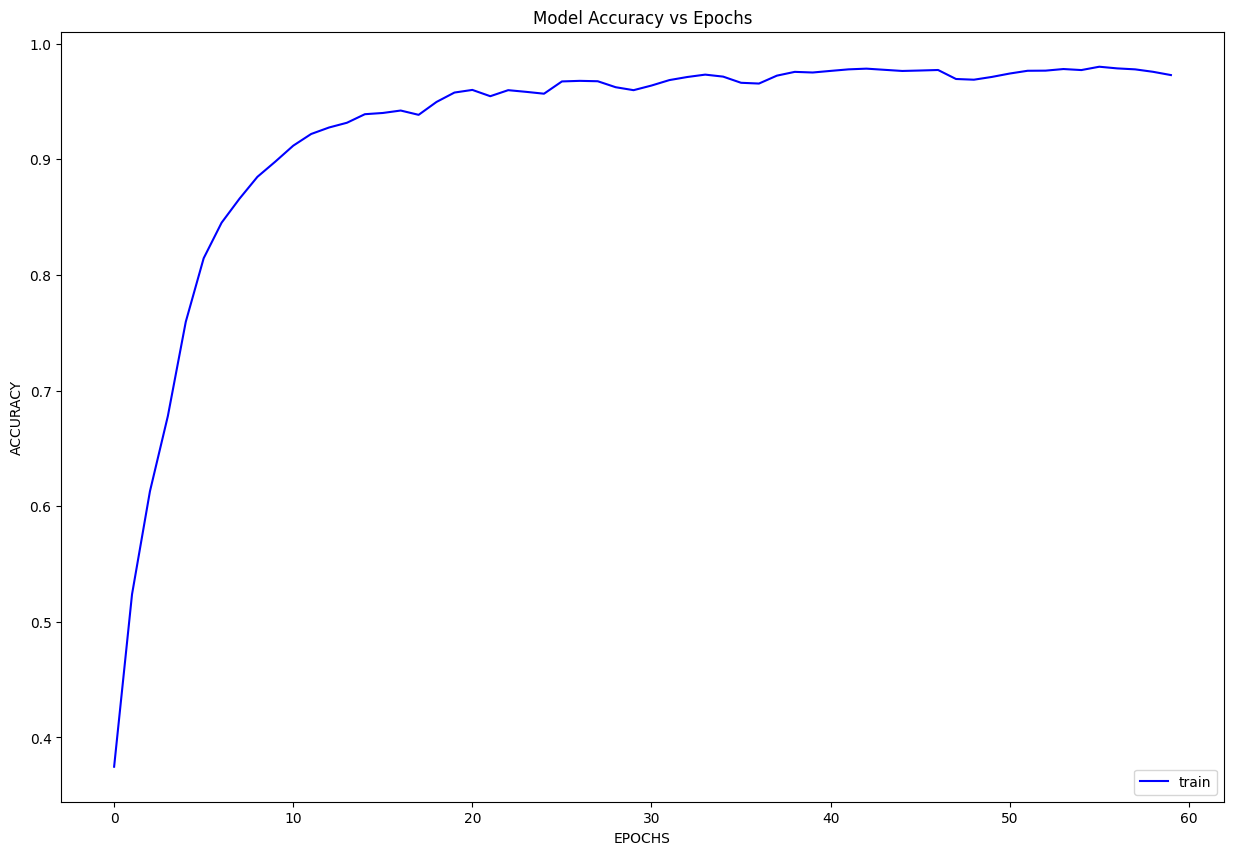

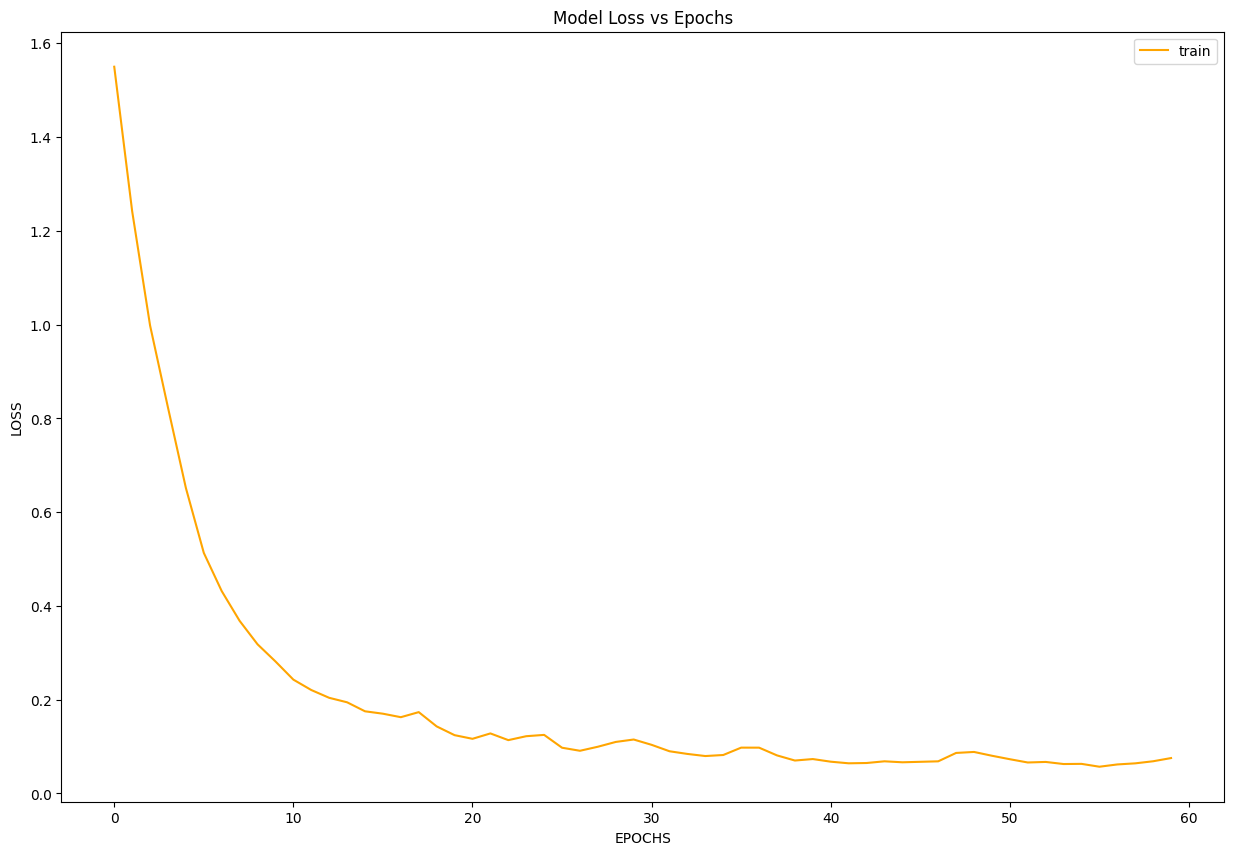

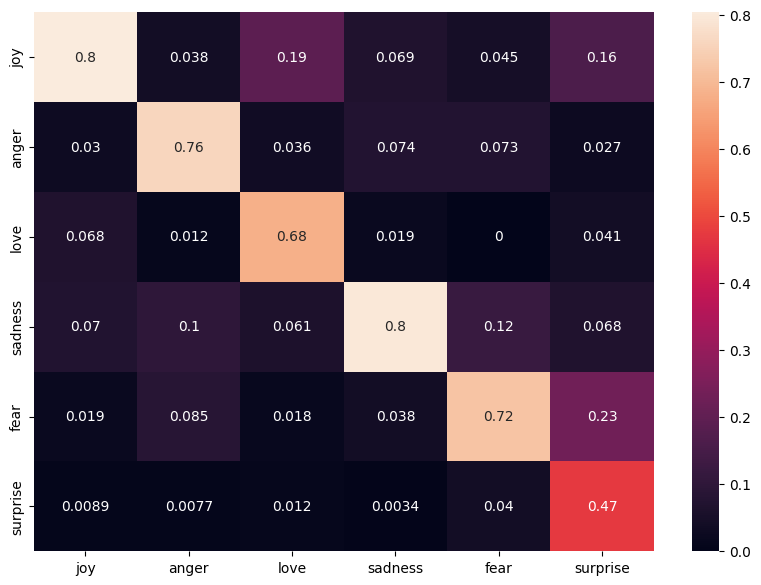

In [14]:
model.plot_train_history()
model.test_model()

## CNN-3

In [15]:
model = Model('GloVe_CNN3', '', 256, 0.1, 'adam', 'categorical_crossentropy', 60)

model.load_dataset()
model.extract_features_and_labels()
model.clean_features()
model.tokenize()
model.make_labels_categorical()
model.split_dataset()
model.glove_word_embedding("glove.6B.300d.txt")

model.init_model()

model.add_layer(Conv1D(128, 3, activation='relu'))
model.add_layer(GlobalMaxPooling1D())
model.add_layer(Dense(64, activation='relu'))
model.add_layer(Dropout(0.5))
model.compile_model(metrics = ['accuracy'])

earlyStopping = EarlyStopping(monitor = 'loss', patience = 10, mode = 'min', restore_best_weights = True)
model.fit([earlyStopping])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 63, 300)           5129100   
                                                                 
 conv1d_4 (Conv1D)           (None, 61, 128)           115328    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 6)                 390       
                                                      

63/63 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       693
           1       0.92      0.90      0.91       270
           2       0.81      0.82      0.81       156
           3       0.93      0.95      0.94       567
           4       0.88      0.87      0.88       254
           5       0.79      0.68      0.73        60

    accuracy                           0.91      2000
   macro avg       0.87      0.86      0.87      2000
weighted avg       0.91      0.91      0.91      2000



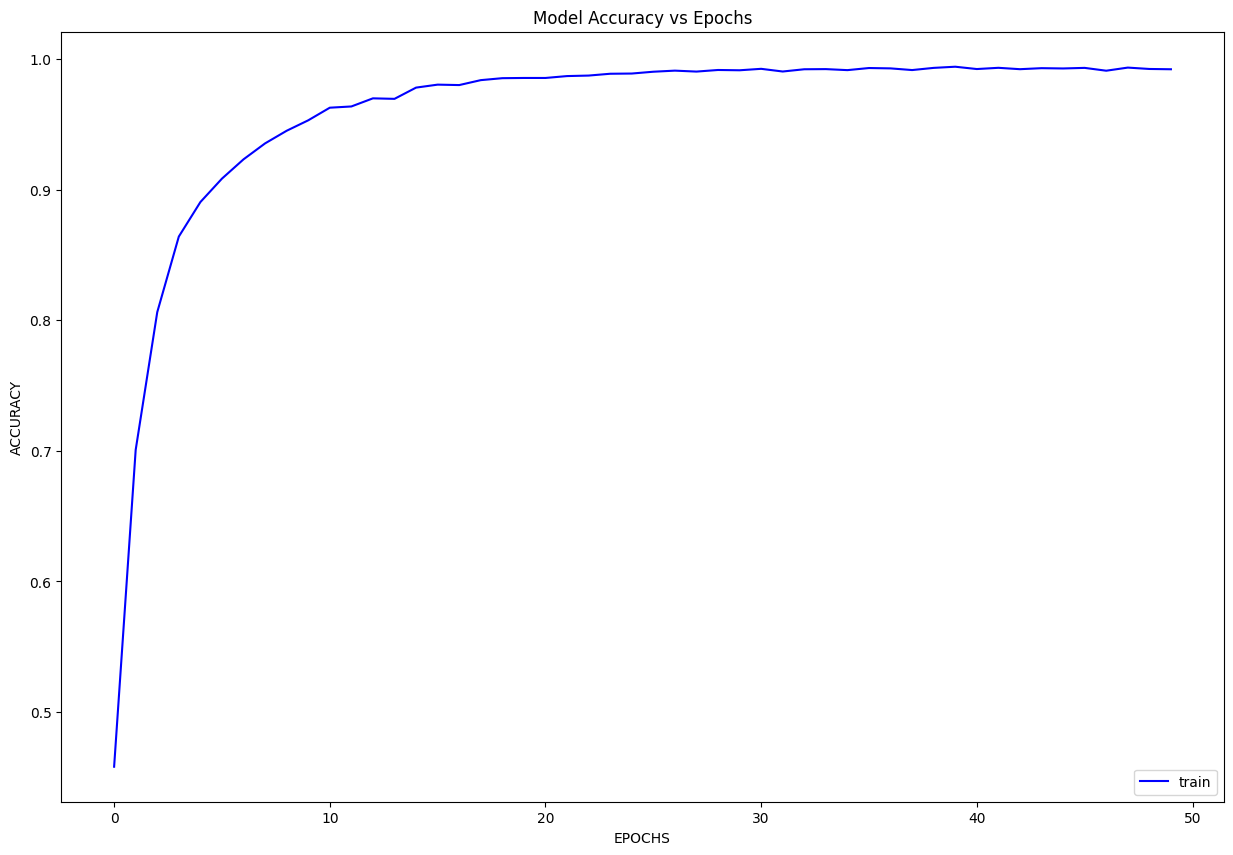

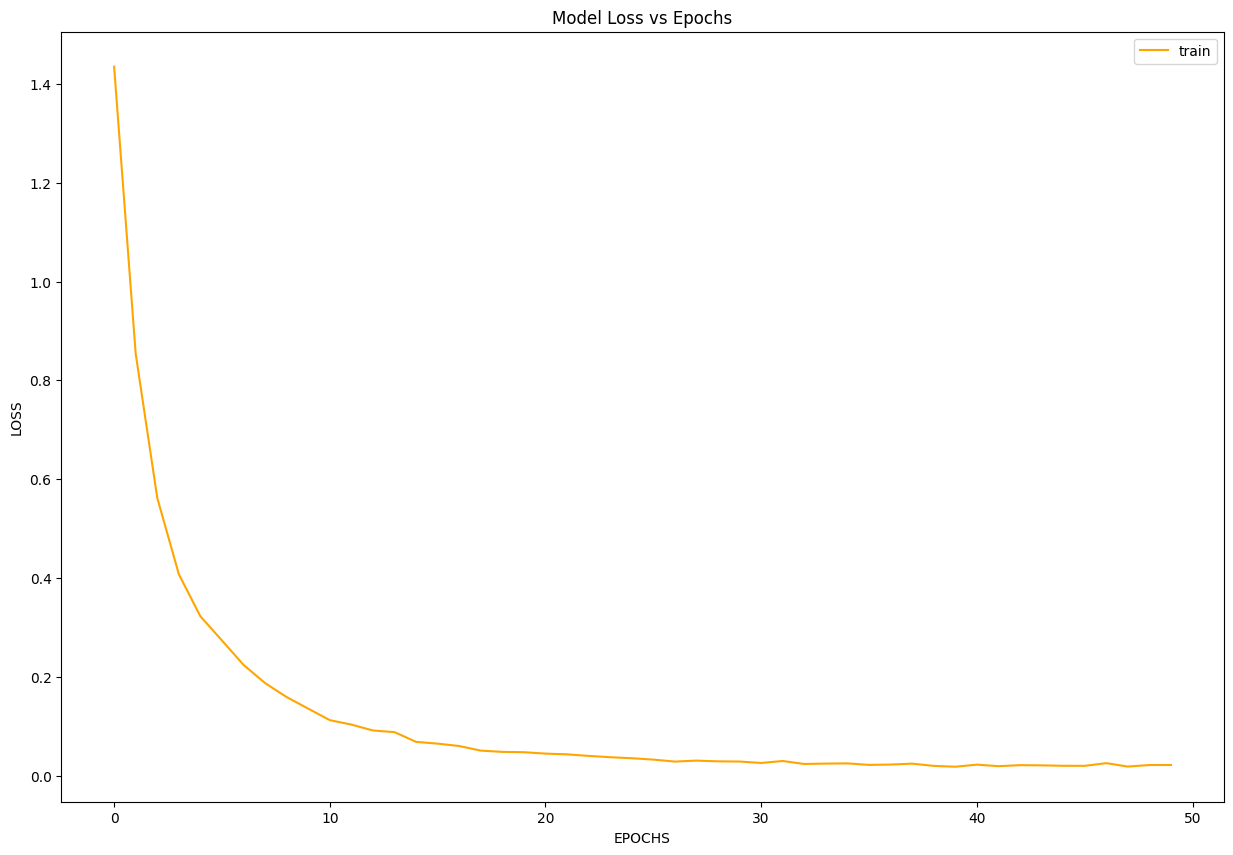

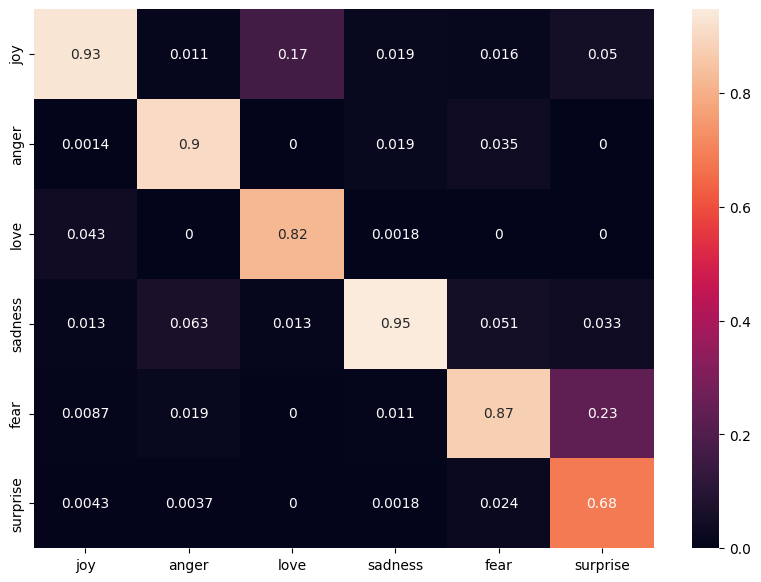

In [16]:
model.plot_train_history()
model.test_model()

## CNN-4

In [17]:
model = Model('GloVe_CNN4', '', 256, 0.1, 'adam', 'categorical_crossentropy', 60)

model.load_dataset()
model.extract_features_and_labels()
model.clean_features()
model.tokenize()
model.make_labels_categorical()
model.split_dataset()
model.glove_word_embedding("glove.6B.300d.txt")

model.init_model()

model.add_layer(Conv1D(128, 3, activation='relu'))
model.add_layer(MaxPool1D())
model.add_layer(Conv1D(128, 3, activation='relu'))
model.add_layer(MaxPool1D())
model.add_layer(Conv1D(128, 3, activation='relu'))
model.add_layer(GlobalMaxPooling1D())
model.add_layer(Dense(64, activation='relu'))
model.add_layer(Dropout(0.5))
model.compile_model(metrics = ['accuracy'])

earlyStopping = EarlyStopping(monitor = 'loss', patience = 10, mode = 'min', restore_best_weights = True)
model.fit([earlyStopping])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 63, 300)           5129100   
                                                                 
 conv1d_5 (Conv1D)           (None, 61, 128)           115328    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 30, 128)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 28, 128)           49280     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 14, 128)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 12, 128)          

63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       669
           1       0.83      0.74      0.78       305
           2       0.66      0.68      0.67       165
           3       0.78      0.85      0.81       588
           4       0.68      0.72      0.70       205
           5       0.56      0.66      0.60        68

    accuracy                           0.77      2000
   macro avg       0.72      0.74      0.73      2000
weighted avg       0.78      0.77      0.77      2000



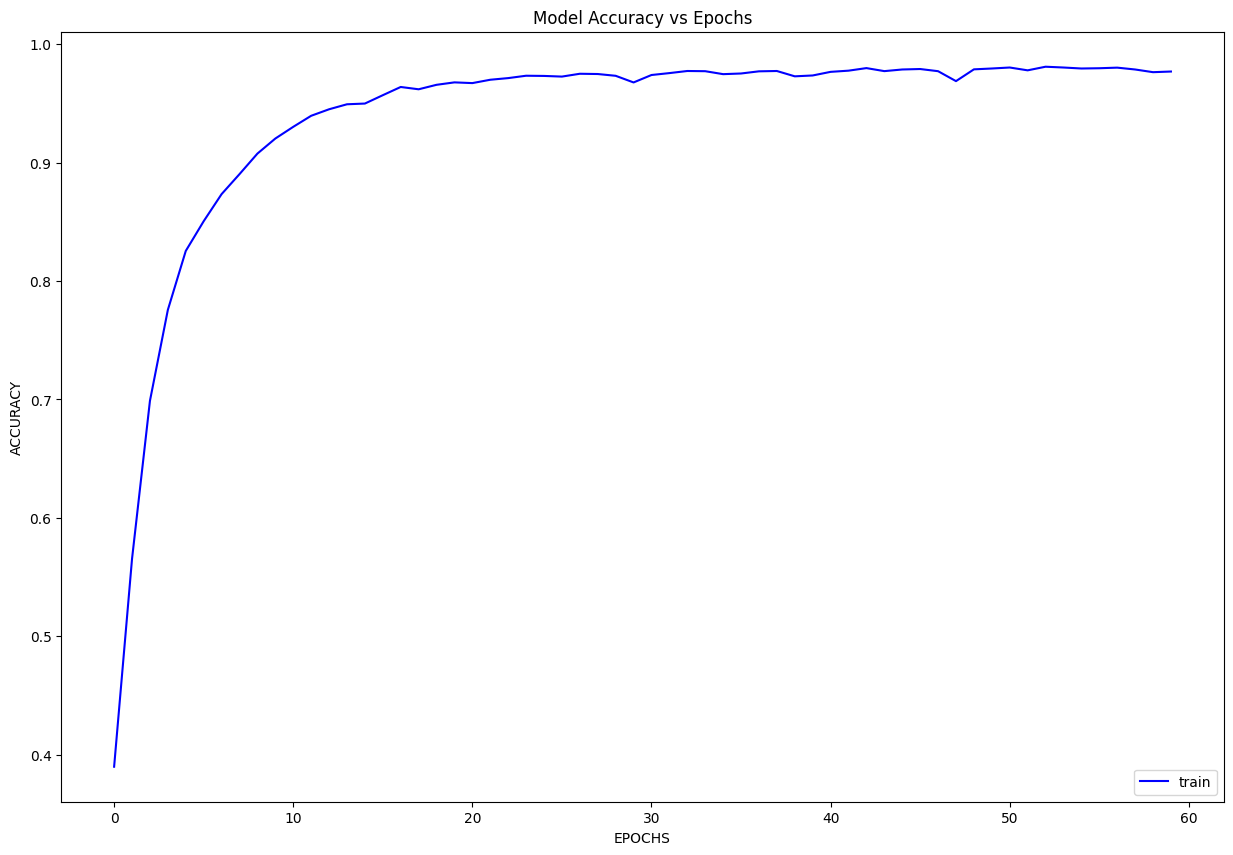

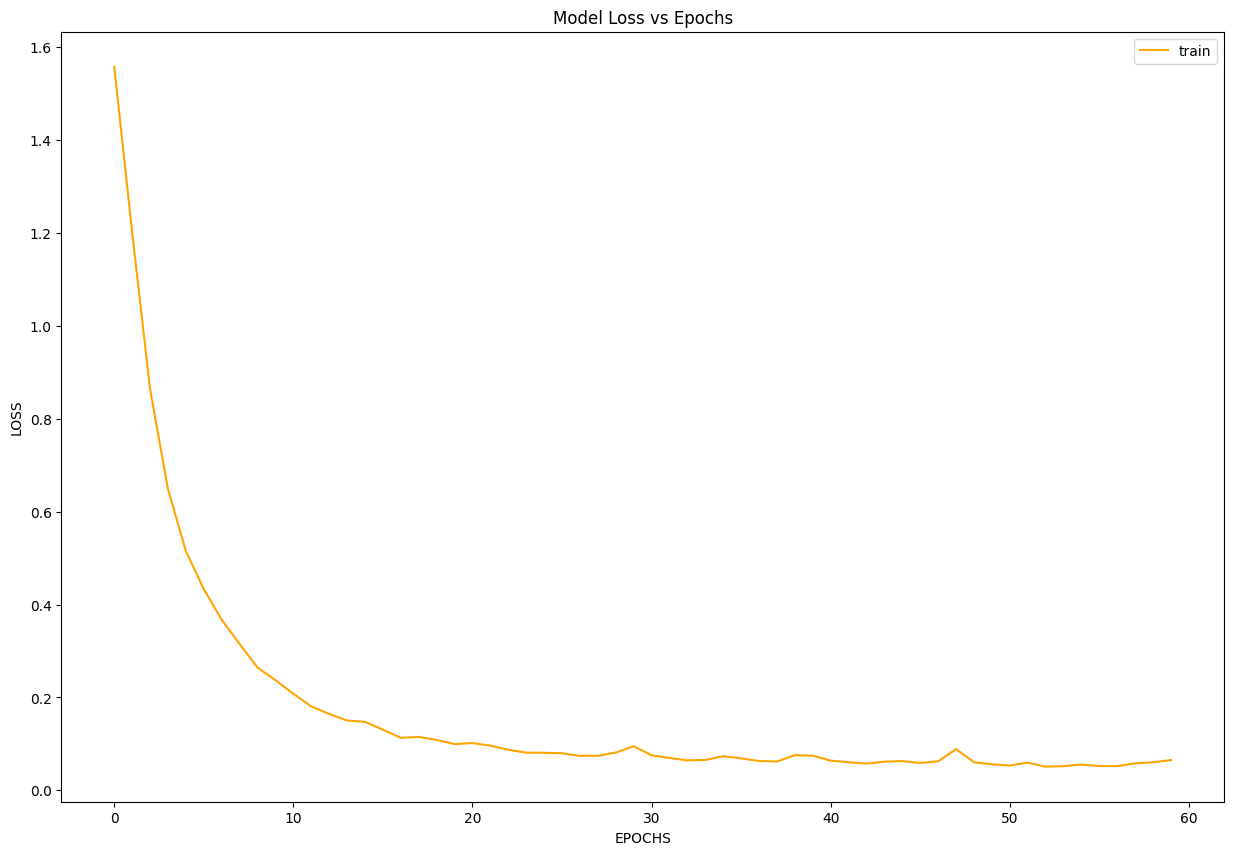

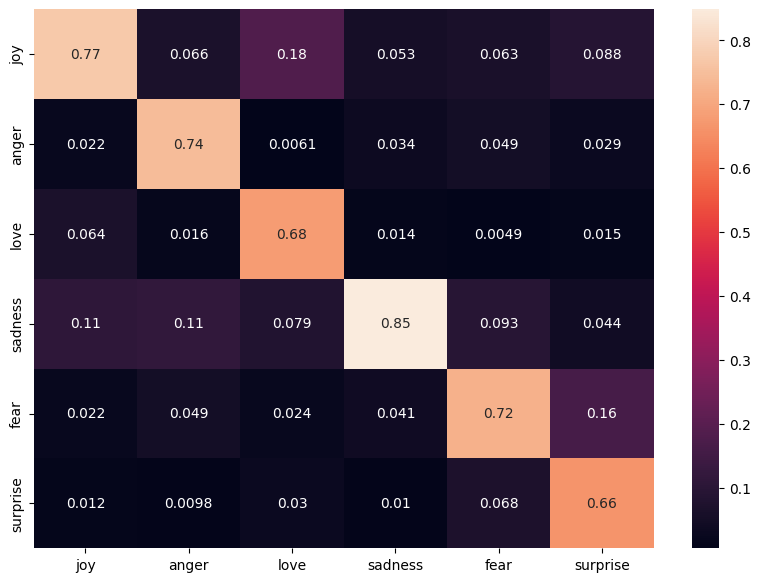

In [18]:
model.plot_train_history()
model.test_model()